# An introduction into the Lightkurve Corrector Class - Noise removal for TESS light curves
Welcome everyone to our *TESS* Lightkurve tutorial!

## Authors

[Rebekah Hounsell](https://heasarc.gsfc.nasa.gov/docs/tess/helpdesk.html) - Support scientist for *TESS* in the NASA GSFC GI Office. 


## Learning Goals

In this tutorial, we will teach the user how to remove scattered light and noise from a *TESS* light curve. 

The tutorial assumes a basic knowledge of python and astronomy, and will walk the user through several of the concepts outlined below,

1. How to use *Lightkurve* to access the various data products and create time series.
2. How to account for instrumental and noise effects within your data using the Corrector class.

This tutorial is designed for users that have previous experience with *Lightkurve*.

## Imports

This tutorial requires the use of specific packages:
- [**Lightkurve**](https://docs.lightkurve.org/index.html) to work with *TESS* data (v2.0.1)
- [**Matplotlib**](https://matplotlib.org/) for plotting.
- [**Numpy**](https://numpy.org) for manipulating the data.

## First time users

If you are not that experienced with *Python*, or cannot download *Lightkurve*, you can run this notebook as a [Colab notebook](https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index). Colaboratory allows users to write and execute *Python* in your browser with zero configuration required. 

All you need is a Google account and to copy and paste in the following command at the top of your colab notebook:

`!pip install lightkurve`

This downloads the *Lightkurve* package.

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## Introduction to the Corrector Class

*TESS* light curves can often have systematic trends caused by noise sources such as scattered light and instrumental effects. Only the [LightCurve objects](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-lightcurve-objects.html) which have been fully processed, have had these effects removed. Data derived from either [TargetPixelFiles](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-targetpixelfile-objects.html) or Full Frame Images must undergo further processing by the user to remove these sources of noise. 

To aid the user in this process, there exist several different tools within the 
*Lightkurve* package. These are known as the [Corrector class](https://docs.lightkurve.org/reference/api/lightkurve.correctors.corrector.Corrector.html?highlight=corrector%20class#lightkurve-correctors-corrector-corrector). We briefly describe each of these corrector classes below,

- [**CBVCorrector**](https://docs.lightkurve.org/reference/api/lightkurve.correctors.CBVCorrector.html?highlight=cbvcorrector): Cotrending Basis Vectors (CBVs) are generated from the most common systematic trends observed in each Sector. Each *TESS* CCD and Camera has its own set of CBVs. There are three basic types of CBVs, 
  - **Single-Scale**: Contains all systematic trends combined in a single set of basis vectors. Generally speaking, a single-scale CBV performs better at preserving longer period signals.
  - **Multi-Scale**: Contains systematic trends in specific wavelet-based band passes. There are usually three sets of multi-scale basis vectors in three bands. This type of correction performs better when the periods are close to the transiting planet durations, and help to preserve the signal.
  - **Spike**: Contains only short impulsive spike systematics. This correction is applied to remove short impulsive systematic signals.
  

- [**RegressionCorrector**](https://docs.lightkurve.org/reference/api/lightkurve.correctors.RegressionCorrector.html?highlight=regressioncorrector): Here the light curve is de-trended against vectors that we think are predictive of the systematic noise. For FFI data, we have to select/define an aperture for our object of interest. Pixels outside of this aperture are used to create vectors that are predictive of the noise. These vectors are then removed from the data.

- [**PLDCorrector**](https://docs.lightkurve.org/reference/api/lightkurve.correctors.PLDCorrector.html?highlight=pldcorrector): Pixel Level De-correlation (PLD) works by identifying a set of trends in the pixels surrounding the target star, and performing linear regression to create a combination of these trends that effectively models the systematic noise introduced by spacecraft motion/scattered light. This noise model is then subtracted from the uncorrected light curve. It is similar to the RegressionCorrector.

In this tutorial, we will apply each of these methods to our data and compare the results. First, we need to obtain the data to test our various Corrector functions.

## 1. How to use *Lightkurve* to access the various data products and create a time series


[*Lightkurve*](https://docs.lightkurve.org/tutorials/index.html) offers a user-friendly way to analyze time series data obtained by telescopes, in particular *TESS*. You can search for the various data products for *TESS* on MAST using the following *Lightkurve* functions.

- To look for your object in a full frame image: [`search_tesscut()`](https://docs.lightkurve.org/reference/api/lightkurve.search_tesscut.html?highlight=search_tesscut)

- To look for target pixel files:  [`search_targetpixelfile()`](https://docs.lightkurve.org/reference/api/lightkurve.search_targetpixelfile.html?highlight=search_targetpixelfile) 

- To obtain light curve files for your object of interest: [`search_lightcurve()`](https://docs.lightkurve.org/reference/api/lightkurve.search_lightcurve.html?highlight=search_lightcurve) 

For the purpose of this tutorial, we will be examining [KT Eri](https://en.wikipedia.org/wiki/KT_Eridani), a bright nova in the constellation Eridanus that underwent an eruption in 2009.

To test our various methods of noise removal, we will be looking at FFI data for this object. We can search [MAST](https://mast.stsci.edu) for TESS FFI data on this object using the [search_tesscut()](https://docs.lightkurve.org/reference/api/lightkurve.search_tesscut.html?highlight=search_tesscut#lightkurve.search_tesscut) function.

In [2]:
search_lc = lk.search_tesscut("KT Eri")
search_lc

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,TESScut,1426,KT Eri,0.0
1,TESS Sector 32,2020,TESScut,475,KT Eri,0.0


We see that there are two sets of data, one from Sector 5 and the other from Sector 32. Let's look at the data from Sector 32. To download the data we must specify a cut out size in pixels and use the [download()](https://docs.lightkurve.org/reference/search.html?highlight=download) function.

<Axes: title={'center': 'Target ID: KT Eri, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

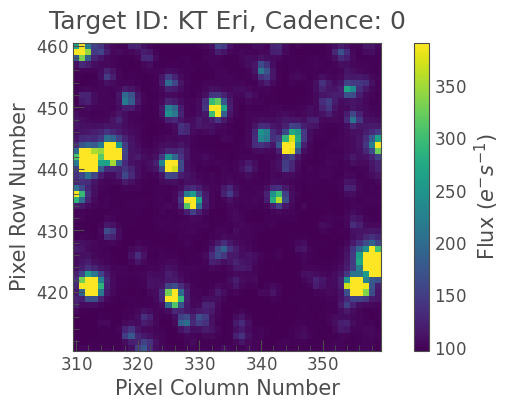

In [3]:
S32 = search_lc[1].download(cutout_size=50)
S32.plot()

Note that this cut out is much larger than a typical FFI, this is because when calculating our noise and systematics, we want a larger sample of pixels from which the correction will be applied.

**Creating our light curve**

Great! Now we have our data, we can create our light curve using the  [to_lightcurve()](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.to_lightcurve.html?highlight=to_lightcurve#lightkurve.KeplerTargetPixelFile.to_lightcurve) function. Our object is in the center, but it is kind of faint in comparison to some other objects. We must therefore create our own aperture as shown below.

<Axes: title={'center': 'Target ID: KT Eri, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

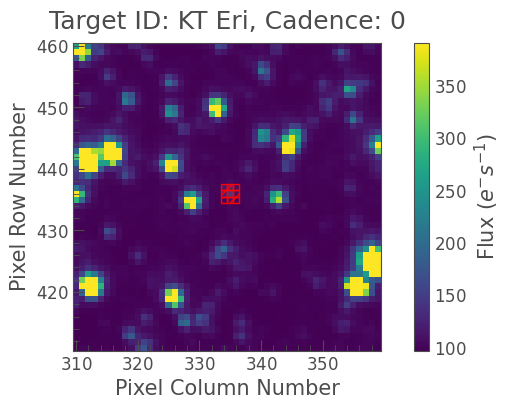

In [6]:
aper_new = np.zeros(S32.shape[1:], dtype=bool)
aper_new[24:27, 24:27] = True
S32.plot(aperture_mask=aper_new, mask_color='red')

Excellent it covers our object! Let's now make our light curve using this aperture and plot the result. 

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

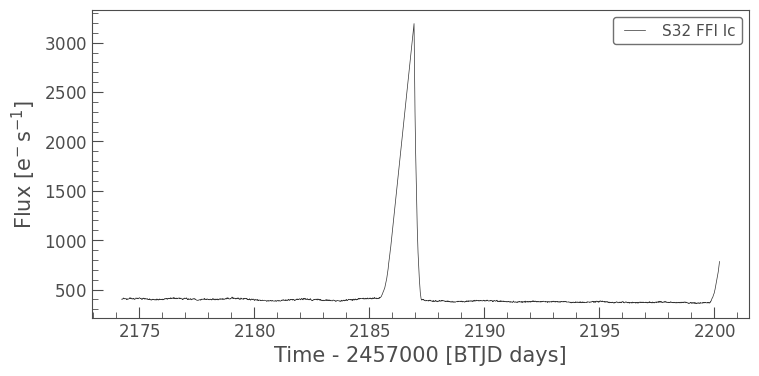

In [17]:
lc_S32 = S32.to_lightcurve(aperture_mask='threshold')
lc_S32.plot(label="S32 FFI lc")

## 2. How to account for instrumental and noise effects within your data using the Corrector class

We can see from the above plot that our light curve is severely affected by scattered light, which needs to be removed. To remove this noise, let's try our first method,

### The CBVCorrector

Here we will use CBVs to remove our noise. 

Check out our [CBV tutorial](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-how-to-use-cbvcorrector.html) for more information.

First, we must import the *CBVCorrector* from *lightkurve.correctors*, and then we can refer to our generate light curve.

In [6]:
from lightkurve.correctors import CBVCorrector
cbvCorrector = CBVCorrector(lc_S32, interpolate_cbvs=True)
cbvCorrector.cbvs

[TESS CBVs, Sector.Camera.CCD : 32.2.4, CBVType : SingleScale, nCBVS : 16,
 TESS CBVs, Sector.Camera.CCD : 32.2.4, CBVType.Band: MultiScale.1, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 32.2.4, CBVType.Band: MultiScale.2, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 32.2.4, CBVType.Band: MultiScale.3, nCBVs : 5,
 TESS CBVs, Sector.Camera.CCD : 32.2.4, CBVType : Spike, nCBVS : 7]

There are 5 sets of CBVs, all associated with Sector 32, Camera 2, CCD 4. The number of CBVs per type is also given. Let’s plot the Single-Scale CBVs, which contain all systematics combined.

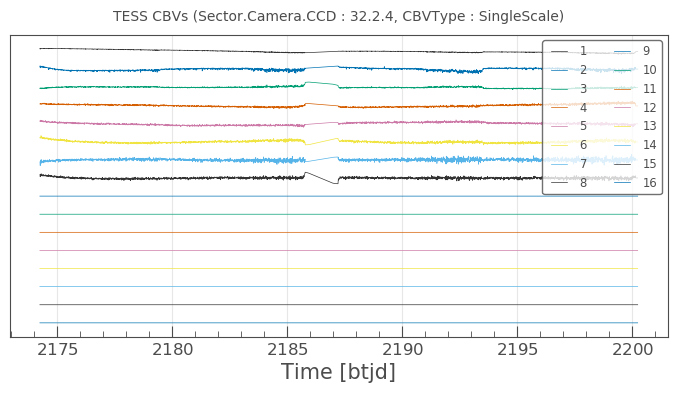

In [7]:
cbvCorrector.cbvs[0].plot()

The first several CBVs contain most of the systematics. The latter CBVs pose a greater risk of injecting more noise than helping. The default behavior in CBVCorrector is to use the first 8 CBVs.

Next, we need to decide what kind of CBV we want to apply. Since we want to try not to overfit, we are going to use the Multi-Scale and Spike options (see above for more details). We can specify the type via an array as indicated below.

In [8]:
cbv_type = ['MultiScale.1', 'MultiScale.2', 'MultiScale.3','Spike']

Since we only want to use the information from the first 8 CBV's when we use the SingleScale function, and all the Spike CBCs, we must also specify this via an array.

In [9]:
cbv_indices = [np.arange(1,9), np.arange(1,9), np.arange(1,9), 'ALL']

Now we want to check that the application of these vectors will not under or over-fit our data. There is a handy way of checking this via the use of a goodness_metric_scan_plot. A "Goodness Metric" value of 0.8 and above tends to indicate a good fit to the data. 

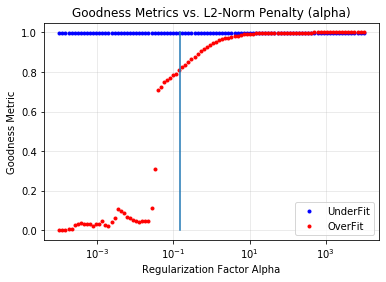

In [10]:
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);
plt.plot([1.5e-1, 1.5e-1], [0,1])

The above plot indicates that a regularization factor alpha value of 1.5e-1 is appropriate for our data. We can now specify this and check it via a diagnose method.

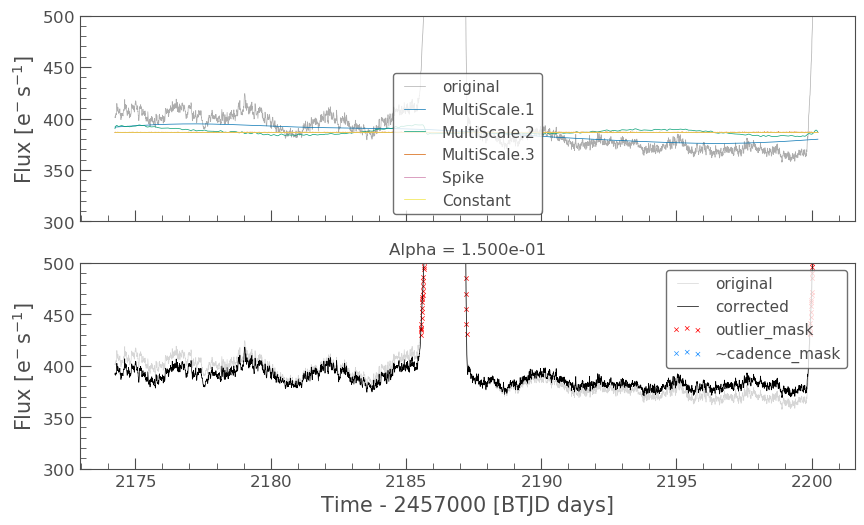

In [11]:
cbvcorrector = CBVCorrector(lc_S32, interpolate_cbvs=True)
cbvcorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1.5e-1)
pltAxis = cbvcorrector.diagnose()
pltAxis[0].set_ylim(300, 500);
pltAxis[1].set_ylim(300, 500);

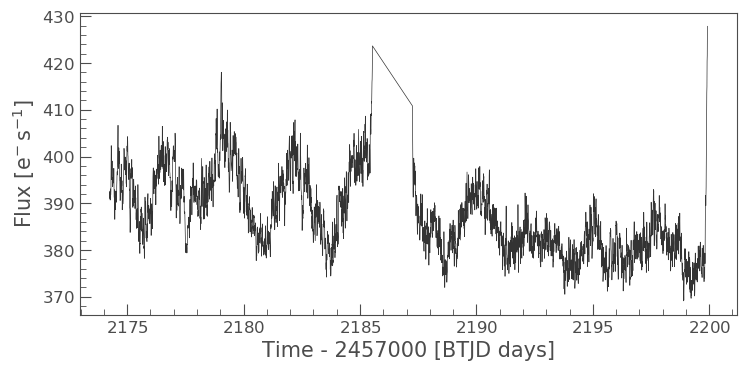

In [12]:
cbvcorrector_lc = cbvcorrector.corrected_lc
cbvcorrector_lc.remove_outliers().plot()

We can see that a correction was applied which has removed some of the slope from our data and also labeled the big spike as an outlier. 

The above method can be adjusted more, but for now, let's move onto our next method.

### The RegressionCorrector

Remember that this method relies on looking at pixels outside of our previously defined object aperture to determine our systematics. We can apply regression correction as follows.

In [4]:
#Import the packages you need
from lightkurve.correctors import RegressionCorrector, DesignMatrix

Next, we are going to define a design matrix which will contain all the systematics detected in the pixels outside of our aperture.

In [12]:
# Make a design matrix and pass it to a linear regression corrector
dm = DesignMatrix(S32.flux[:, ~aper_new], name='regressors')#.pca(5).append_constant()

 We only want the most dominant vectors and so specify the number of principle componant (PCA) as follows,

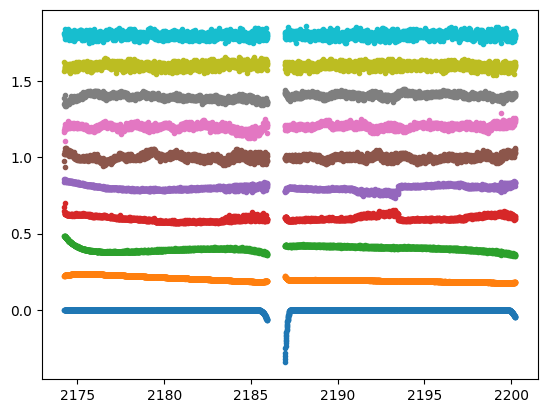

In [13]:
dm = dm.pca(10)
plt.plot(S32.time.value, dm.values + np.arange(10)*0.2, '.');

From this we can see that 10 is excessive and we should probably use only 5. Let's do this and plot it up.

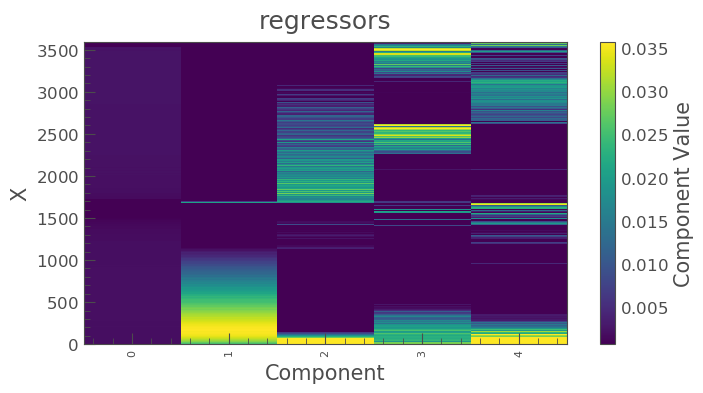

In [16]:
dm = DesignMatrix(S32.flux[:, ~aper_new], name='regressors').pca(5)
dm.plot()


*Lightkurve’s RegressionCorrector* uses linear algebra to find the combination of vectors that makes the input light curve closest to zero. We therefore needed to add one more component - an “offset” term, to be able to fit the mean level of the light curve. We can do this as shown above by appending a“constant” to the design matrix.



In [14]:
dm = DesignMatrix(S32.flux[:, ~aper_new], name='regressors').pca(5).append_constant()

Next we pass this design matrix to the *RegressionCorrector* which de-trends the light curves against the vectors. 

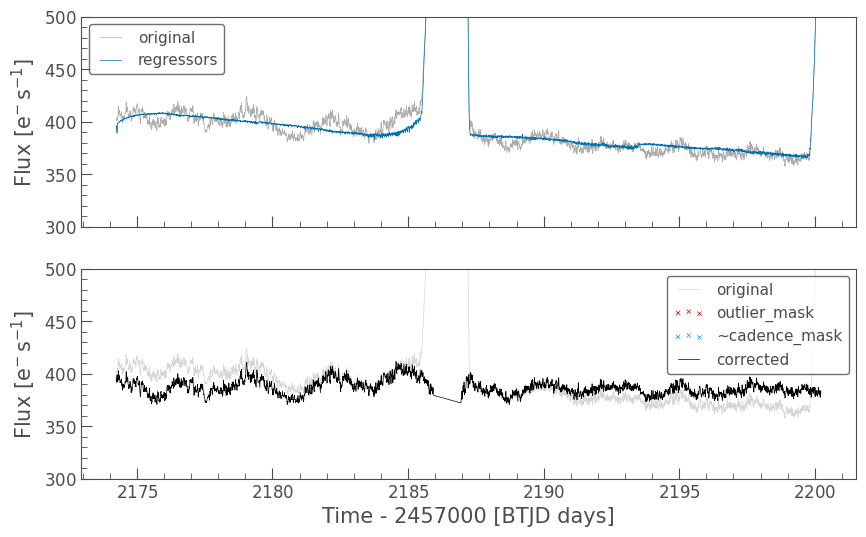

In [19]:
rc = RegressionCorrector(lc_S32)
rc.correct(dm)
pltAxis = rc.diagnose()
pltAxis[0].set_ylim(300, 500);
pltAxis[1].set_ylim(300, 500);

corrected_ffi_lc = rc.correct(dm)


**HOWEVER!** The *RegressionCorrector* assumes that you want to remove the trend and set the light curve to the mean level. 

This isn’t true for *TESS* scattered light, as the *TESS* FFI light curves have an additive background. As such, we want to reduce the flux to the lowest recorded level.

To do this, we can look at the model of the background that *RegressionCorrector* built and apply that.  This model should never go below zero, to ensure that this is the case we only subtract the model flux value at the 5th percentile.

We can then apply all these factors to the FFI light curve using the following code,

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

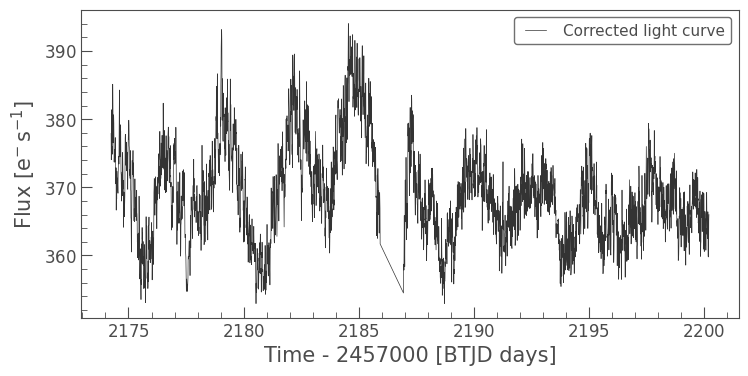

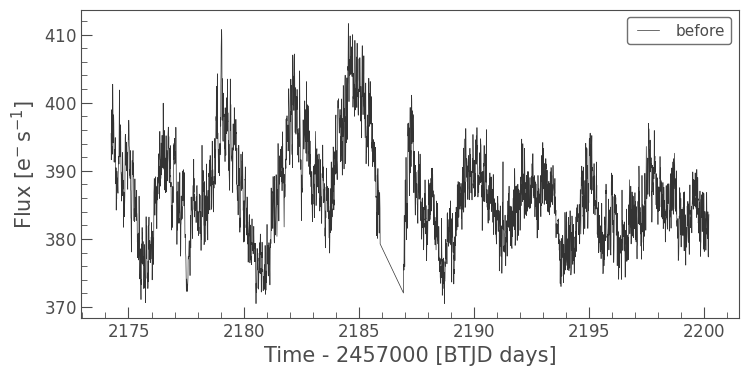

In [25]:
# Optional: Remove the scattered light, allowing for the large offset from scattered light
corrected_ffi_lc = lc_S32 - rc.model_lc + np.percentile(rc.model_lc.flux, 5)
corrected_ffi_lc.plot(label='Corrected light curve');

This has removed all the scattered light and the slope, but again could be adjusted further. However, we will move onto our final tool.

### The PLDCorrector

PLD is built on top of *RegressionCorrector* and again works by identifying a set of trends in the pixels surrounding the target star, and performing linear regression to create a combination of these trends that effectively models the noise. This noise model is then subtracted from the uncorrected light curve. The difference between *PLDCorrector* and *RegressionCorrector* is that *RegressionCorrector* asks the user to define the pixels, where as *PLDCorrector* does not.

We will create a *PLDCorrector* object, and use the default values for PLDCorrector.correct to remove this scattered light background.


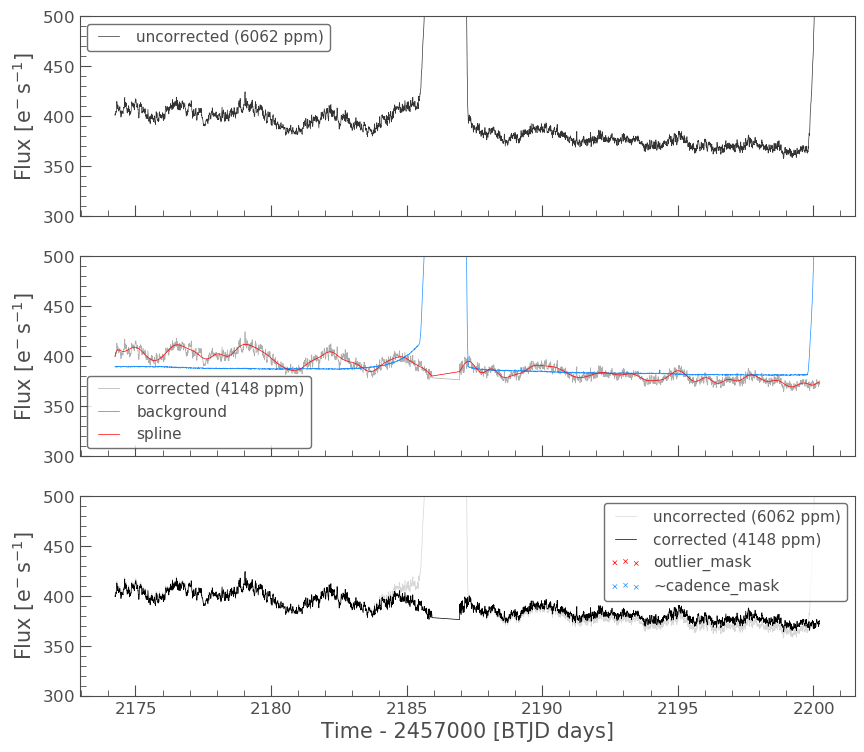

In [20]:
from lightkurve.correctors import PLDCorrector
pld_S32 = PLDCorrector(S32)
pld_S32.correct(pca_components=5)
pltAxis = pld_S32.diagnose()
pltAxis[0].set_ylim(300, 500);
pltAxis[1].set_ylim(300, 500);
pltAxis[2].set_ylim(300, 500);

corrected_pldlc = pld_S32.correct(pca_components=5)

We can also examine the apertures used to perform this correction. For *TESS*, the dominant source of noise is the scattered light background, so by default only those pixels will be used. In the third panel, we can see that the background_aperture_mask contains only background pixels, reducing the risk of contamination by neighboring stars.

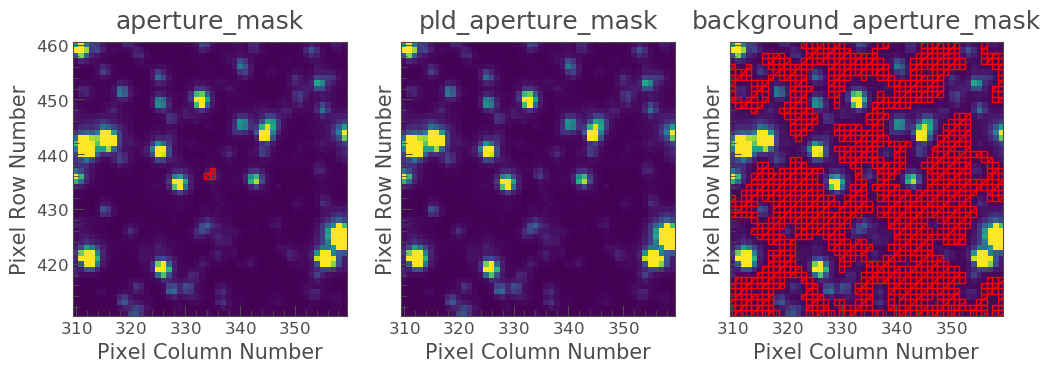

In [21]:
pld_S32.diagnose_masks();

Now lets specifically look at our corrected light curve. 

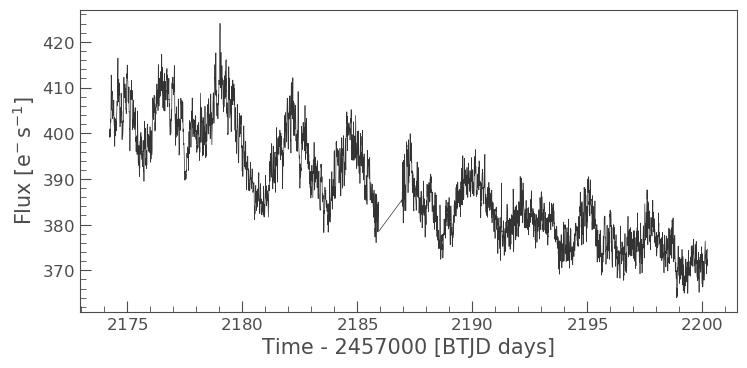

In [22]:
corrected_pldlc.plot()

The large spike from the scattered light has sucessfully been identified and removed, but there is a slope in our data still. We can determine from the diagnostic plots that this is due to the application of a flat background, unlike that which was applied in *RegressionCorrection*.

Note that there are various componants that can be altered in *PLD* most of which can be found [here](https://docs.lightkurve.org/reference/api/lightkurve.correctors.PLDCorrector.correct.html?highlight=pca_components). 

## Comparison

Let's now plot up all of our corrected light curves in addition to the light curve originally derived from the FFI's, and compare our results. 

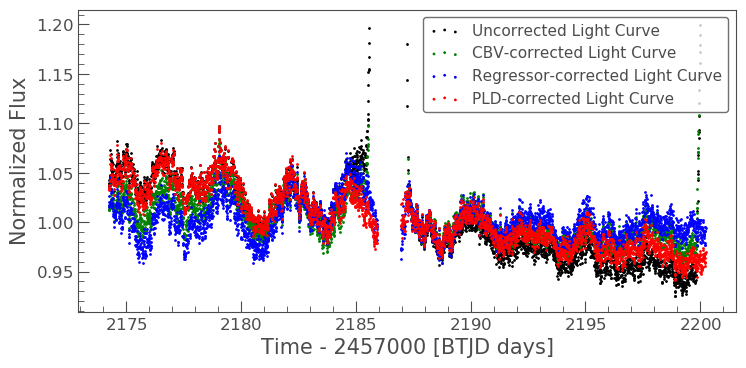

In [23]:
# Lets plot and compare the different methods 
ax = lc_S32.normalize().remove_outliers().scatter(color='black', label='Uncorrected Light Curve');
# Plot the CBV-corrected light curve in green
cbvcorrector_lc.normalize().remove_outliers().scatter(ax=ax, color='green', label='CBV-corrected Light Curve')
# Plot the regressor-corrected light curve in blue
corrected_ffi_lc.normalize().remove_outliers().scatter(ax=ax, color='blue', label='Regressor-corrected Light Curve')
# Plot the PLD-corrected light curve in red 
corrected_pldlc.normalize().remove_outliers().scatter(ax=ax, color='red', label='PLD-corrected Light Curve')

## Summary

The plot above indicaates that there is no one solution. The result from the *RegressionCorrector* seems to have removed the most scattered light and the slope in the data, whilst retaining the periodicity. 

As you may have discovered, removing the noise from the data can be a complex issue with multiple paths. You should always examine your method of noise removal and inspect all final products. 

The tutorials listed below will aid you in better understanding the fine details of each process.

- [Removing noise from Kepler, K2, and TESS light curves using Cotrending Basis Vectors (CBVCorrector)](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-how-to-use-cbvcorrector.html)
- [Removing scattered light from TESS light curves using linear regression (RegressionCorrector)](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-removing-scattered-light-using-regressioncorrector.html)
- [Removing noise from K2 and TESS light curves using Pixel Level Decorrelation (PLDCorrector)](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-k2-pldcorrector.html)


